# Loading the data

In [1]:
#cd /Users/akshitasingh/Downloads/273A_ML/1_MLProject

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
np.random.seed(0)

from collections import defaultdict

np.random.seed(100)

In [3]:
# sklearn imports
from sklearn import preprocessing
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder

# other stats/math imports
import math
from scipy.stats import chi2_contingency

In [4]:
#diabetes = pd.read_csv("/Users/akshitasingh/Downloads/273A_ML/1_MLProject/dataset_diabetes/diabetic_data.csv", delimiter=None) 
diabetes = pd.read_csv("diabetic_data.csv", delimiter=None) 
diabetes = pd.DataFrame(diabetes)

In [5]:
diabetes.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


# Data Preprocessing
### Numerical Features 
In this dataset the feature names make numerical value features self-evident. Each column with numerical features starts with "num_..."
### Categorical Features
Essentially every feature that is numerical can be considered categorical but it is not as simple as that. 
1) 2 features are patient ID features: ['encounter_id', 'patient_nbr']. It does not make sense to include them (unless we are considering a personalized Machine Learning model) <br>
2) It also does not make sense to include the target feature which is also categorical: ['readmitted'] <br>
3) Certain features have numerical values that represent categories, such as: ['admission_type_id', 'discharge_disposition_id', 'admission_source_id']. This is something we will investigate further. 


In [6]:
# list column names of features that consist of numeric values
# (in this dataset the feature names make numerical value features self-evident)
feat_num = ['num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses']

# numerics = ['int16','int32','int64','float16','float32','float64']
# feat_num = list(diabetes.select_dtypes(include=numerics).columns)

# list column names of features that consist of categorical values
feat_cat = ['race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty', 'diag_1',
       'diag_2', 'diag_3', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed']

#### Count distinct values for Categorical Features

In [7]:
cat_count = defaultdict(int)
for f in feat_cat:
    cat_count[f] = len(diabetes[f].value_counts())
cat_count

defaultdict(int,
            {'race': 6,
             'gender': 3,
             'age': 10,
             'weight': 10,
             'admission_type_id': 8,
             'discharge_disposition_id': 26,
             'admission_source_id': 17,
             'time_in_hospital': 14,
             'payer_code': 18,
             'medical_specialty': 73,
             'diag_1': 717,
             'diag_2': 749,
             'diag_3': 790,
             'max_glu_serum': 4,
             'A1Cresult': 4,
             'metformin': 4,
             'repaglinide': 4,
             'nateglinide': 4,
             'chlorpropamide': 4,
             'glimepiride': 4,
             'acetohexamide': 2,
             'glipizide': 4,
             'glyburide': 4,
             'tolbutamide': 2,
             'pioglitazone': 4,
             'rosiglitazone': 4,
             'acarbose': 4,
             'miglitol': 4,
             'troglitazone': 2,
             'tolazamide': 3,
             'examide': 1,
             'citogl

In [8]:
# The features "examide" and "citoglipton" have only one value through so they can be dropped from consideration
diabetes = diabetes.drop(['examide', 'citoglipton'], axis = 1)
feat_cat = [f for f in feat_cat if f not in ('examide', 'citoglipton')]

In [9]:
# List of all medication features after removing  "examide" and "citoglipton"
medications = list(diabetes.columns)[24:45]

## Categorical features - Investigating Categories
We picked some features we thought would be relevant to look into further <br>

### Discharge Disposition ID: 
From the ID mapping that UCI ML Repository shared with us, some categories here relate to death or terminally ill facilities. Any patient that falls into these categories should possibly not be considered in our predictions because there is no way they can be readmitted. If we were to consider them, we would possibly be biasing our predictions towards "NO" readmission, which would be incorrect. Nonetheless, we might want to consider some patients who had multiple re-admissions and hence we will not completely eliminate all patients that fall in the death/hospice categories

In [10]:
## drop rows where discharge_disposition_id indicates death or hospice
# diabetes = diabetes.drop(diabetes[diabetes.discharge_disposition_id.isin([11,13,14,19,20,21])].index)
## OR, Create a Boolean for patients that died/went to hospice vs that didn't
diabetes['disposition_boolean'] = np.where((diabetes['discharge_disposition_id'].isin([11,13,14,19,20,21])),1,0)
diabetes['discharge_disposition_id'].value_counts()
feat_cat.append('disposition_boolean')

### Diagnosis Features - diag_1, diag_2, diag_3: 
- Each of the 3 features containts 700+ categories of type string <br> 
- Some of these categories are essentially numbers (floats) while others are hard strings <br>
- We convert all the strings that can be converted into floats, and coerce the others into 'nan' <br>
- Any unknowns (?) and non-float diagnisis (ex. V50) are then categorized as "Other" 

In [11]:
def diag_cat(diag_feat):
    diabetes[diag_feat] = pd.to_numeric(diabetes[diag_feat],errors= 'coerce')
    diabetes[diag_feat] = diabetes[diag_feat].fillna(0)
    
    for ind in range(len(diabetes)):
        if diabetes[diag_feat][ind] == 'nan':
            diabetes[diag_feat][ind] = "Other"
        elif round(diabetes[diag_feat][ind]) in [250,251]:
            diabetes[diag_feat][ind] = "Diabetes"
        elif diabetes[diag_feat][ind] in range(390,460) or diabetes[diag_feat][ind] == 785:
            diabetes[diag_feat][ind] = "Circulatory"
        elif diabetes[diag_feat][ind] in range(460,520) or diabetes[diag_feat][ind] == 786:
            diabetes[diag_feat][ind] = "Respiratory"
        elif diabetes[diag_feat][ind] in range(520,580) or diabetes[diag_feat][ind] == 787:
            diabetes[diag_feat][ind] = "Digestive"
        elif diabetes[diag_feat][ind] in range(800,1000):
            diabetes[diag_feat][ind] = "Injury"
        elif diabetes[diag_feat][ind] in range(710,740):
            diabetes[diag_feat][ind] = "Musculoskeletel"
        else:
            diabetes[diag_feat][ind] = "Other"

In [12]:
diag_feat = ['diag_1', 'diag_2', 'diag_3']

for f in diag_feat:
    diag_cat(f)

/var/folders/t3/g9mr20m16kl6hwxm4flsx9mc0000gn/T/ipykernel_72143/2306081007.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diabetes[diag_feat][ind] = "Diabetes"
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/var/folders/t3/g9mr20m16kl6hwxm4flsx9mc0000gn/T/ipykernel_72143/2306081007.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

In [13]:
diabetes['diag_1'].value_counts()

Circulatory        30437
Other              26728
Respiratory        14423
Digestive           9475
Diabetes            8772
Injury              6974
Musculoskeletel     4957
Name: diag_1, dtype: int64

### Gender, Age, Admissions Type, and Admissions Source
Age is a categorical feature, which we can consider turning into a numerical value by finding the mean of each range. This converts the feature into a numeric (but we shall not consider this as part of PCA because we understand that Age is an important factor in understanding readmissions and hence should not be put under the dimensionality reduction bucket. <br>

In [14]:
# Gender
diabetes = diabetes[diabetes['gender'] != 'Unknown/Invalid']
diabetes['gender'].value_counts()

# Age
age_dict = {'[0-10)' : 5,
'[10-20)' : 15,
'[20-30)' : 25, 
'[30-40)' : 35, 
'[40-50)' : 45, 
'[50-60)' : 55,
'[60-70)' : 65, 
'[70-80)' : 75,
'[80-90)' : 85,
'[90-100)' : 95}

diabetes['age'] = diabetes['age'].apply(lambda x : age_dict[x])

# Admissions
diabetes['admission_type_id'] = \
diabetes['admission_type_id'].apply(lambda x : 'Unavailable' if int(x) in [5, 6, 8]
                                                            else 'Elective')



diabetes['admission_source_id'] = \
diabetes['admission_source_id'].apply(lambda x : 'Referral' if int(x) in [5, 6, 8]
                                            else ('Emergency Room' if int(x) in [7]
                                            else 'Other'))


## Investigating Multiple Readmissions
Some patients show up more than once in our dataset. It is a very small subset of the larger dataset so we first start with considering only once patient visit - which, in our case, would be the very last occurance for that patient. 

In [15]:
## Count the number of multiple readmissions for a single patient
# data = diabetes[diabetes['readmitted'] != 'NO']
# unique_patients = data[['patient_nbr']]
# unique_patients = unique_patients['patient_nbr'].value_counts().to_frame()
# unique_patients["index"] = unique_patients.index
# len(unique_patients[unique_patients["patient_nbr"] > 1])

In [16]:
diabetes = diabetes.drop_duplicates(subset= 'patient_nbr', keep='last')
diabetes.shape

(71515, 49)

## Investigating Missing Values (?) 
Features with missing values: <br>
**Weight** - replaced it with the mode <br>
Another way to impute the missing weights would have been to find the closest neighbors. For us, a "neighbor" would be another patient with similar comorbidities. These comorbidities could be respresented in multiple ways such as (1) diagonasis (dia_1, 2, and 3) 2) number of meds, <br>
**Race** - replaced it with "UNK" <br>
**Medical Speciality** - replaced it with "UNK" <br>
**Payer Code** - replaced it with "UNK" <br>

(**diag_1, diag_2, diag_3** also had missing values but those have already been handled above)

In [17]:
for col in diabetes.columns:
    if diabetes[col].dtype == object:
        count = diabetes[col][diabetes[col] == '?'].count()
        if count > 0:
            print(col, count)

race 1876
weight 68668
payer_code 30084
medical_specialty 34523


In [18]:
## Weights: Because most weights are missing, we replace the ? with most common weight
diabetes['weight'] = np.where((diabetes['weight'] == "?"),"[75-100)",diabetes['weight'])
## Race: replace with UNK
diabetes['race'] = np.where((diabetes['race'] == "?"),"UNK",diabetes['race'])
## Medical Speciality: replace with UNK
diabetes['medical_specialty'] = np.where((diabetes['medical_specialty'] == "?"),"UNK",diabetes['medical_specialty'])
## payer_code: replace with UNK
diabetes['payer_code'] = np.where((diabetes['race'] == "?"),"UNK",diabetes['payer_code'])

In [19]:
# drop payer_code because it doesn't seem to explain very much 
# drop medical speciality because it has too many missing values
feat_cat = [f for f in feat_cat if f not in ('payer_code', 'medical speciality')]

### Data after Preprocessing

In [20]:
X = diabetes[feat_num + feat_cat]
y = diabetes['readmitted']

# Train Test Split

In [21]:
Xtr, Xte, Ytr, Yte = train_test_split(X, y, test_size=0.3, random_state=1)

# Feature Selection

In [22]:
# convert numerical features from strings to floats
for f in feat_num:
    diabetes[f] = pd.to_numeric(diabetes[f],errors= 'coerce')
    
scaler = StandardScaler()

# scaling training data
Xtr_num = Xtr[feat_num]
scaler.fit(Xtr_num)
Xtr_numSc = scaler.fit_transform(Xtr_num)

# transforming test data based on the fit from training data
Xte_num = Xte[feat_num]
Xte_numSc = scaler.transform(Xte_num)

In [23]:
# construct the new training data with scaled features
Xtr_cat = np.array(Xtr[feat_cat])
Xtr = np.concatenate([Xtr_numSc, Xtr_cat], axis = 1)
Xtr = pd.DataFrame(Xtr)
Xtr.columns = [feat_num + feat_cat]

# construct the new test data with the scaled features
Xte_cat = np.array(Xte[feat_cat])
Xte = np.concatenate([Xte_numSc, Xte_cat], axis = 1)
Xte = pd.DataFrame(Xte)
Xte.columns = [feat_num + feat_cat]

## Feature Selection - Numerical Features  (Principal Component Analysis)

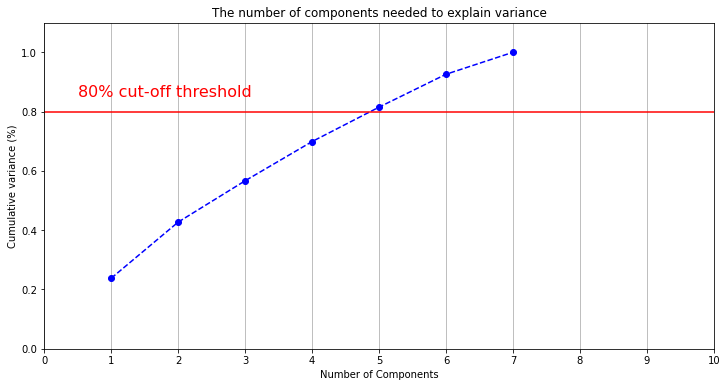

In [24]:
pca = PCA().fit(Xtr_numSc)

plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, 8, step=1)
Var = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, Var, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 11, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.8, color='r', linestyle='-')
plt.text(0.5, 0.85, '80% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

In [25]:
# compoonents that explain 90% of the variances 
pca = PCA(n_components=5)

# fit PCA on the training data
XtrPCA_num = pca.fit_transform(Xtr_numSc)
XtrPCA_num = pd.DataFrame(XtrPCA_num)
XtrPCA_num.columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5']
# XtrPCA_num

# transform test data based on the PCA fit from training
XtePCA_num = pca.transform(Xte_numSc)
XtePCA_num = pd.DataFrame(XtePCA_num)
XtePCA_num.columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5']
# XtePCA_num

## Feature Selection - Categorical Features 

### Step 1: Investigate the value count for each medication
If we realize that hardly anyone was prescribed that medication, it is perhaps a good idea to not consider it in our analysis <br>

We run the risk of excluding patients that were specifically chosen for rare medications which hardly prescribed (and hence eliminated from our feature set). 

In [26]:
threshold = 70000

med_count = defaultdict(list)

for med in medications:
    # count the number of Nos, Ups, Downs, and Steadys for each medication
    med_count[med].append(list(diabetes[med].value_counts()))
    
    # if the number of Nos is > 100K, disregard the medication for now 
    if med_count[med][0][0] > threshold:
        med_count.pop(med)
med_count
meds_new = list(med_count)
# meds_new

### Step 2: Chi Square

Lets first try to find any relations between the medication features <br>

#### Approach 1: Cross Tabulation
$D$ = Number of Medication features <br>
Null Hypothesis ($H_O$): Features are independent - there is no relationship between features $x^i$ and $x^j$ where $i, j$ $\in$ $(1,...,D)$ <br>
Alternate Hypothesis ($H_1$): Features are independent - there is a relationship between features <br>
Let's consider p-value for $H_O$ = .05 $\Rightarrow$ if p-value for a relation is < .05, then we fail to reject $H_O$ <br>

As we can see, none of our p-values are greater than the significance level, so we fail to reject the null hypothesis for any of them. Thus, we continue to consider all the medication features to be independent from each other. 

In [27]:
chi_p = [[0]*7 for _ in range(7)]
for med1 in meds_new:
    for med2 in meds_new:
        chi_p[meds_new.index(med1)][meds_new.index(med2)] = chi2_contingency(pd.crosstab(diabetes[med1], diabetes[med2]))[1]
chi_p = np.array(chi_p)   
# chi_p       

### Final set of categorical features

In [28]:
# disposition id replaced by the booleans
feat_catN = ['gender', 'age', 'weight', 'admission_type_id', 'admission_source_id', 'disposition_boolean',
           'time_in_hospital'] + diag_feat + meds_new + ['change', 'diabetesMed']

In [29]:
Xtr_cat = Xtr[feat_catN]
Xte_cat = Xte[feat_catN]

## Final Train and Test Data with Selected Catagorical Features and PCAs 

In [30]:
features = list(XtrPCA_num.columns) + feat_catN

# final training data 
Xtr = np.concatenate([np.array(XtrPCA_num), np.array(Xtr_cat)], axis = 1)
Xtr = pd.DataFrame(Xtr)
Xtr.columns = features
# Xtr

# final test data
Xte = np.concatenate([np.array(XtePCA_num), np.array(Xte_cat)], axis = 1)
Xte = pd.DataFrame(Xte)
Xte.columns = features
# Xte

## One Hot Encode the Final Set of Categorical Features (If needed)

In [31]:
# Features to One Hot Encode
feat_OHE = ['gender', 'weight', 'admission_type_id', 'admission_source_id', 'disposition_boolean'] + \
            diag_feat + meds_new + ['change', 'diabetesMed']
Xtr_OHE = Xtr[feat_OHE]


# fit OHE on to the training data
OHE = OneHotEncoder(categories='auto')
Xtr_OHE = OHE.fit_transform(Xtr_OHE).toarray()
Xtr_OHE = pd.DataFrame(Xtr_OHE)

# transform OHE fit into test data
Xte_OHE = Xte[feat_OHE]
Xte_OHE = OHE.transform(Xte_OHE).toarray()
Xte_OHE = pd.DataFrame(Xte_OHE)

In [32]:
# extract column names for OHE categories
OHE_cols = []
OHE_cols_ = OHE.categories_
for col, vals in zip(Xtr_OHE.columns, OHE_cols_):
    for val in vals:
        name = str(col) + '_' + str(val)
        OHE_cols.append(name)

Xtr_OHE.columns = OHE_cols
Xte_OHE.columns = OHE_cols

In [33]:
Xtr = pd.concat([XtrPCA_num, Xtr_OHE], axis = 1)
Xte = pd.concat([XtePCA_num, Xte_OHE], axis = 1)

In [34]:
Xtr.shape

(50060, 76)

In [35]:
Xte.shape

(21455, 76)

# Train Models 

In [36]:
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler

xTrain, xTest, yTrain, yTest = Xtr.copy(), Xte.copy(), Ytr.copy(), Yte.copy() 
yTrain = Ytr.reset_index(drop = True)
yTest = Yte.reset_index(drop = True)
xTrain = xTrain[yTrain!="NO"].reset_index(drop = True)
yTrain = yTrain[yTrain!="NO"].reset_index(drop = True)
xTest = xTest[yTest!="NO"].reset_index(drop = True)
yTest = yTest[yTest!="NO"].reset_index(drop = True)
xTrainOriginal, yTrainOriginal = xTrain.copy(), yTrain.copy()

smote = SMOTE(random_state=0)
xTrain, yTrain = smote.fit_resample(xTrain, yTrain)

In [37]:
xTrain.head()

,PC1,PC2,PC3,PC4,PC5,0_Female,0_Male,1_>200,1_[0-25),1_[100-125),...,13_Steady,13_Up,14_Down,14_No,14_Steady,14_Up,15_Ch,15_No,16_No,16_Yes
0,-1.001114,-0.178816,1.419157,-0.241848,1.679107,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
1,-1.154761,1.002315,-0.154103,0.280256,-0.202405,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
2,-1.283819,0.090347,-1.014163,0.374683,1.585651,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
3,0.881744,-0.920512,0.293280,0.206973,-0.152122,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
4,0.905045,2.074435,-0.009024,2.439239,1.021444,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0


In [38]:
yTrainOriginal.value_counts()

>30    9753
<30    2238
Name: readmitted, dtype: int64

In [39]:
xTrain.shape

(19506, 76)

In [40]:
xTest.shape

(5153, 76)

In [41]:
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

In [42]:
xTrain

,PC1,PC2,PC3,PC4,PC5,0_Female,0_Male,1_>200,1_[0-25),1_[100-125),...,13_Steady,13_Up,14_Down,14_No,14_Steady,14_Up,15_Ch,15_No,16_No,16_Yes
0,-1.001114,-0.178816,1.419157,-0.241848,1.679107,1.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,1.000000,0.0,1.0
1,-1.154761,1.002315,-0.154103,0.280256,-0.202405,0.000000,1.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,1.000000,0.0,1.0
2,-1.283819,0.090347,-1.014163,0.374683,1.585651,1.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,1.000000,0.0,1.0
3,0.881744,-0.920512,0.293280,0.206973,-0.152122,1.000000,0.000000,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.000000,0.000000,0.0,1.0
4,0.905045,2.074435,-0.009024,2.439239,1.021444,1.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,1.000000,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19501,1.730299,3.169834,-1.930625,1.115850,-1.359099,0.000000,1.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.821762,0.178238,0.0,1.0
19502,0.903193,0.671386,-0.720298,-0.437791,-0.636851,0.000000,1.000000,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.000000,0.000000,0.0,1.0
19503,0.731780,0.702163,0.612118,-1.020263,1.047060,1.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,1.000000,0.0,1.0
19504,0.662405,-0.332158,0.273859,-0.615259,-0.194779,1.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,1.000000,0.0,1.0


In [43]:
aggCluster = AgglomerativeClustering(n_clusters=2, linkage = "complete").fit(xTrainOriginal).labels_

In [44]:
sum(yTrainOriginal == ">30")/len(yTrainOriginal)

0.8133600200150113

In [45]:
sum(pd.Series(aggCluster)==0)/len(aggCluster)

0.9998332082395129

In [46]:
from random import sample

In [47]:
splits = []
seeds = np.sqrt(sample(range(1000000),100)).astype(int)
for i in seeds:
    kCluster = KMeans(n_clusters=2, random_state=i).fit(xTrainOriginal).labels_
    bigger = sum(pd.Series(kCluster)==0)
    smaller = sum(pd.Series(kCluster)==1)
    if bigger < smaller:
        bigger = smaller
    splits.append(bigger/len(kCluster))
splits = np.array(splits)

In [48]:
# splits

array([0.87740806, 0.87740806, 0.87740806, 0.87740806, 0.87740806,
       0.87740806, 0.87740806, 0.87740806, 0.87740806, 0.87740806,
       0.87740806, 0.87740806, 0.87740806, 0.87740806, 0.87740806,
       0.87740806, 0.87740806, 0.87740806, 0.87740806, 0.87740806,
       0.87740806, 0.87740806, 0.87740806, 0.87740806, 0.87740806,
       0.87740806, 0.87740806, 0.87740806, 0.87740806, 0.87740806,
       0.87740806, 0.87740806, 0.87740806, 0.87740806, 0.87740806,
       0.87740806, 0.87740806, 0.87740806, 0.87740806, 0.87740806,
       0.87740806, 0.87740806, 0.87740806, 0.87740806, 0.87740806,
       0.87740806, 0.87740806, 0.87740806, 0.87740806, 0.87740806,
       0.87740806, 0.87740806, 0.87740806, 0.87740806, 0.87740806,
       0.87740806, 0.87740806, 0.87740806, 0.87740806, 0.87740806,
       0.87740806, 0.87740806, 0.87740806, 0.87740806, 0.87740806,
       0.87740806, 0.87740806, 0.87740806, 0.87740806, 0.87740806,
       0.87740806, 0.87740806, 0.87740806, 0.87740806, 0.87740

In [79]:
splits = []
#seeds = np.sqrt(sample(range(1000000),100)).astype(int)
for i in range(100):
    kCluster = KMeans(n_clusters=2, random_state=i).fit(xTrainOriginal).labels_
    bigger = sum(pd.Series(kCluster)==0)
    smaller = sum(pd.Series(kCluster)==1)
    if bigger < smaller:
        bigger = smaller
    splits.append(bigger/len(kCluster))
splits = np.array(splits)

In [80]:
kCluster = KMeans(n_clusters=2, random_state=100).fit(xTrainOriginal).labels_

In [81]:
kSplit = sum(kCluster==0)/len(kCluster)
kSplit

0.8774080560420315

In [82]:
def showKmeans(x,y,z):
    x = str(x)
    y = str(y)
    z = str(z)
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.scatter(xTrainOriginal[["PC" + x]], xTrainOriginal[["PC" + y]], xTrainOriginal[["PC" + z]], c = kCluster)
    plt.title("K-means with principal components " + x + ", "+ y + ", " + z + ", " + " as axes")
    ax.set_xlabel('principal component ' + x)
    ax.set_ylabel('principal component ' + y)
    ax.set_zlabel('principal component ' + z)
    #plt.savefig('kmeans.png')

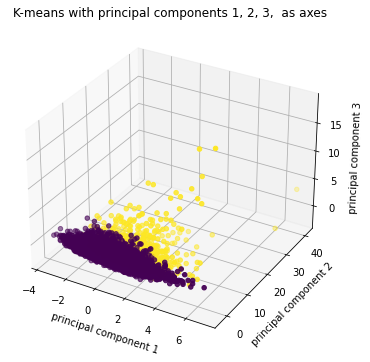

In [440]:
showKmeans(1,2,3)

In [444]:
def showLabels(x,y,z):
    x = str(x)
    y = str(y)
    z = str(z)
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.scatter(xTrainOriginal[["PC" + x]], xTrainOriginal[["PC" + y]], xTrainOriginal[["PC" + z]], \
        c = (yTrainOriginal==">30").astype(int))
    plt.title("Original labels with principal components " + x + ", "+ y + ", " + z + ", " + " as axes")
    ax.set_xlabel('principal component ' + x)
    ax.set_ylabel('principal component ' + y)
    ax.set_zlabel('principal component ' + z)
    #plt.savefig('origLabels.png')

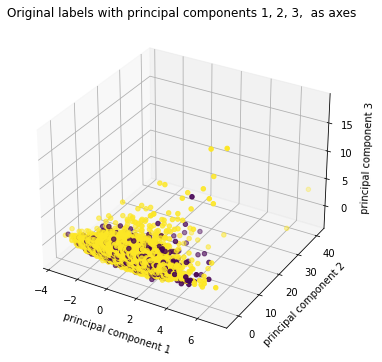

In [445]:
showLabels(1,2,3)

Text(0.5, 1.0, 'k means')

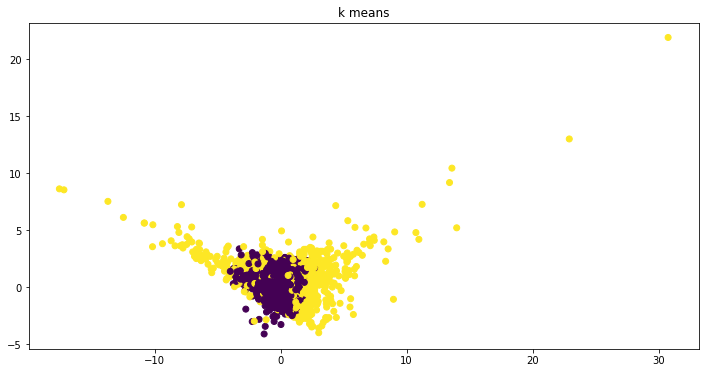

In [86]:
plt.scatter(xTrainOriginal[["PC4"]], xTrainOriginal[["PC5"]], c = kCluster)
plt.title("k means")

Text(0.5, 1.0, 'labeled data')

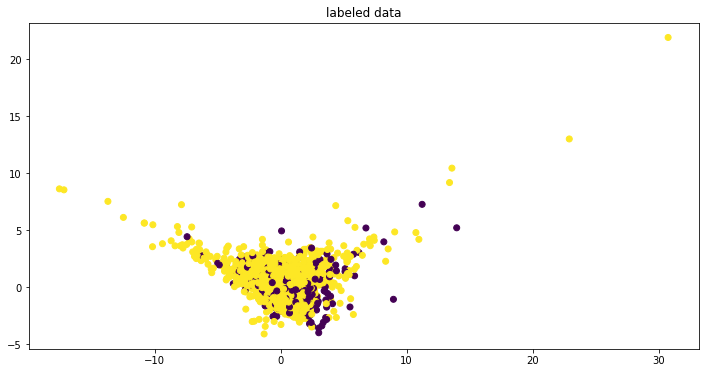

In [87]:
plt.scatter(xTrainOriginal[["PC4"]], xTrainOriginal[["PC5"]], \
           c = (yTrainOriginal==">30").astype(int))
plt.title("labeled data")

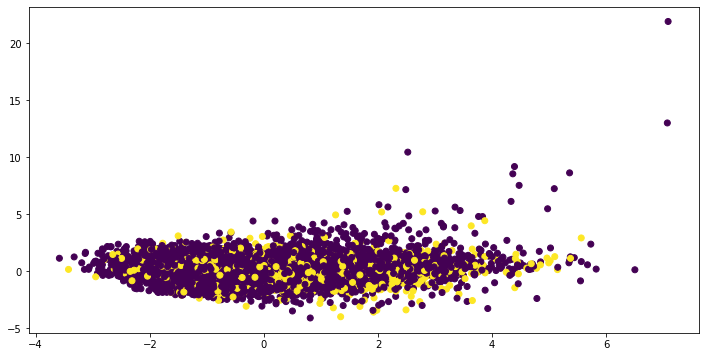

In [88]:
plt.scatter(xTrainOriginal[["PC1"]], xTrainOriginal[["PC5"]], c = (yTrainOriginal=="<30").astype(int))

In [89]:
kSplit

0.8774080560420315

In [90]:
tSplit = sum(yTrain == ">30")/len(yTrain)

In [91]:
tSplit

0.5

In [92]:
np.random.default_rng(3)

Generator(PCG64) at 0x177EB7310

In [93]:
yTrain.unique()

array(['>30', '<30'], dtype=object)

In [94]:
from random import sample

In [95]:
np.sqrt(sample(range(1000000),100)).astype(int)

array([814, 706, 391, 754, 886, 705, 814, 862, 909, 915, 669, 663, 741,
       967, 683, 705, 923, 598, 968, 495, 256, 780,  82, 816, 773, 817,
       860, 872, 720, 675, 767,  88, 264, 367, 986, 127, 213, 696, 493,
       857, 751, 982, 533, 560, 961, 437, 967, 602, 365, 621, 103, 987,
       618, 594, 350, 632, 843, 921, 837, 240, 738, 416, 960, 758, 576,
       307, 923, 652, 436, 624, 577, 792, 867, 646, 292, 695, 900, 592,
       425, 340, 781, 837, 760, 324, 425, 843, 368, 333, 927, 736, 675,
       841, 974, 825, 954, 336, 659, 936, 898, 755])

In [302]:
from sklearn.model_selection import cross_val_score
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import metrics

In [382]:
#xSmote = xTrain
#ySmote = yTrain
#xTrain = xTrainOriginal
#yTrain = yTrainOriginal
xTrain = xSmote
yTrain = ySmote

In [380]:
ySmote.value_counts()

>30    9753
<30    9753
Name: readmitted, dtype: int64

In [383]:
yTrain.value_counts()

>30    9753
<30    9753
Name: readmitted, dtype: int64

In [404]:
indices = np.array(xTrain.index)
indices = indices[1:len(indices)] # this is to enable even splits for 5 folds
np.random.shuffle(indices)
folds = np.split(indices, 47)
def showaucs(alg):
    aucs = []
    foldNums = list(range(len(folds)))
    for i in foldNums:
        valIndices = folds[i]
        xVal = xTrain.iloc[valIndices]
        yVal = yTrain.iloc[valIndices]
        trainIndices = np.array([folds[x] for x in nums if x!=i]).flatten()
        xFit = xTrain.iloc[trainIndices]
        yFit = yTrain.iloc[trainIndices]
        model = alg.fit(xFit, yFit)
        preds = model.predict(xVal)
        fpr, tpr, thresholds = metrics.roc_curve(yVal=="<30", preds=="<30")
        aucs.append(metrics.auc(fpr, tpr))
    plt.hist(aucs)
    plt.xlim(0,1)

In [125]:
svmLinear = svm.SVC(kernel='linear', random_state=100)

svmRBF = svm.SVC(kernel='rbf', random_state=100)

svmPoly = svm.SVC(kernel='poly', random_state=100)

dTree = DecisionTreeClassifier(random_state=0)

rForest = RandomForestClassifier(criterion = "entropy")

gBoost = GradientBoostingClassifier()

knn = KNeighborsClassifier(n_neighbors = 1)

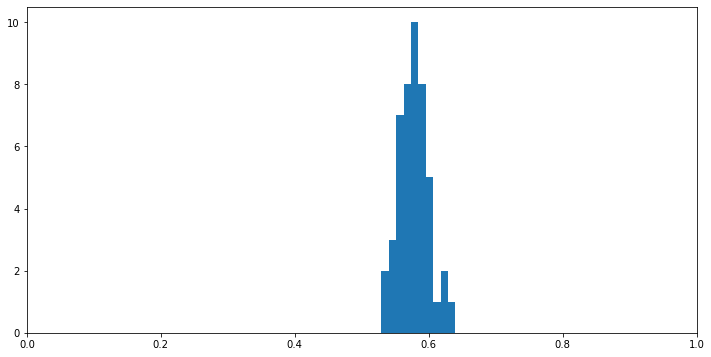

In [361]:
showaucs(svmLinear)

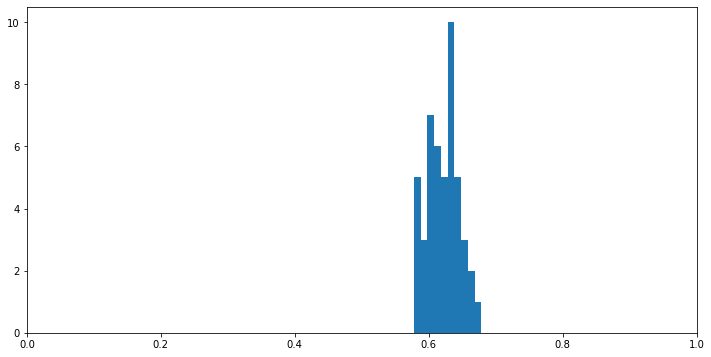

In [359]:
showaucs(svmPoly)

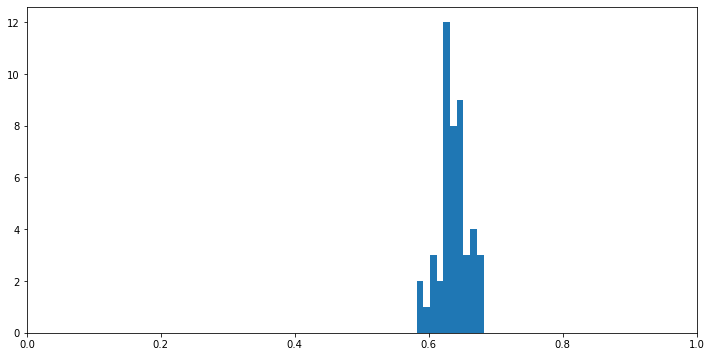

In [360]:
showaucs(svmRBF)

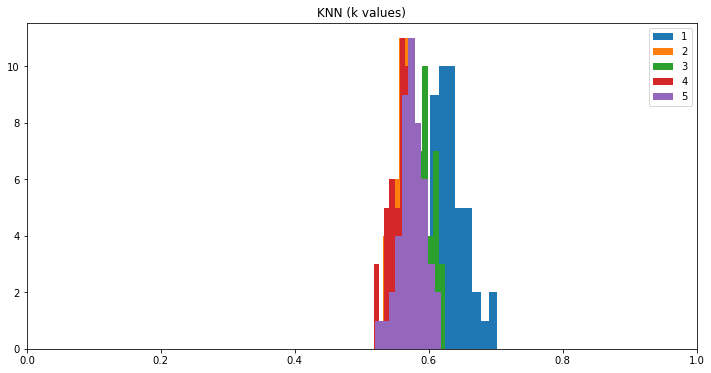

In [388]:
showaucs(KNeighborsClassifier(n_neighbors = 1))
showaucs(KNeighborsClassifier(n_neighbors = 2))
showaucs(KNeighborsClassifier(n_neighbors = 3))
showaucs(KNeighborsClassifier(n_neighbors = 4))
showaucs(KNeighborsClassifier(n_neighbors = 5))
plt.title("KNN (k values)")
plt.legend([1,2,3,4,5])

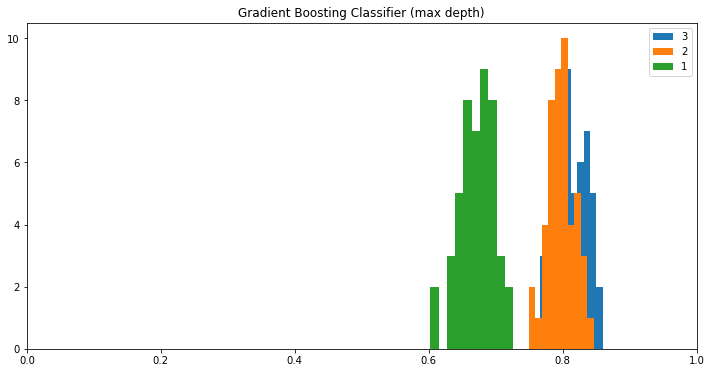

In [390]:
showaucs(GradientBoostingClassifier(max_depth=3))
showaucs(GradientBoostingClassifier(max_depth=2))
showaucs(GradientBoostingClassifier(max_depth=1))
plt.title("Gradient Boosting Classifier (max depth)")
plt.legend([3,2,1])

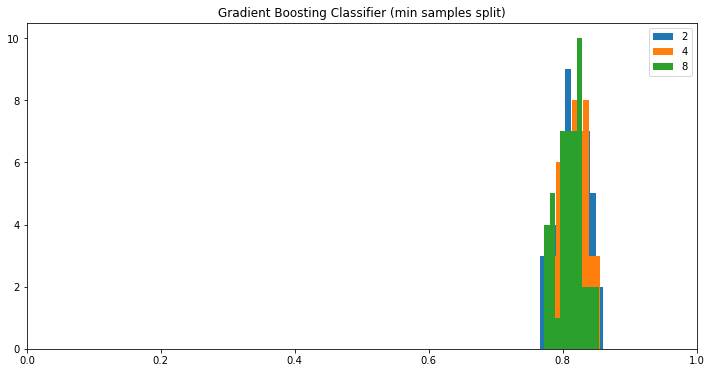

In [389]:
showaucs(GradientBoostingClassifier(min_samples_split=2))
showaucs(GradientBoostingClassifier(min_samples_split=4))
showaucs(GradientBoostingClassifier(min_samples_split=8))
plt.title("Gradient Boosting Classifier (min samples split)")
plt.legend([2,4,8])

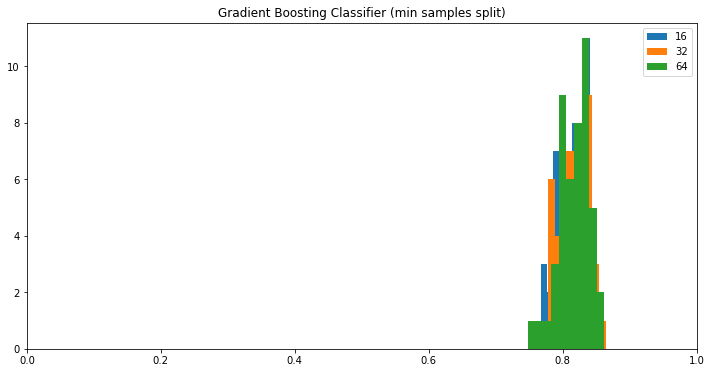

In [394]:
showaucs(GradientBoostingClassifier(min_samples_split=16))
showaucs(GradientBoostingClassifier(min_samples_split=32))
showaucs(GradientBoostingClassifier(min_samples_split=64))
plt.title("Gradient Boosting Classifier (min samples split)")
plt.legend([16,32,64])

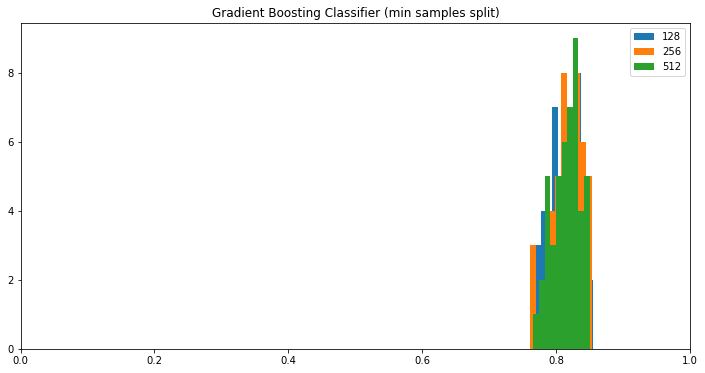

In [393]:
showaucs(GradientBoostingClassifier(min_samples_split=128))
showaucs(GradientBoostingClassifier(min_samples_split=256))
showaucs(GradientBoostingClassifier(min_samples_split=512))
plt.title("Gradient Boosting Classifier (min samples split)")
plt.legend([128,256,512])

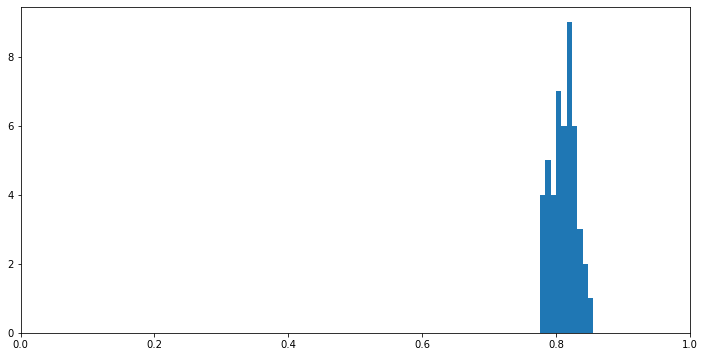

In [405]:
showaucs(GradientBoostingClassifier(min_samples_split=1000))

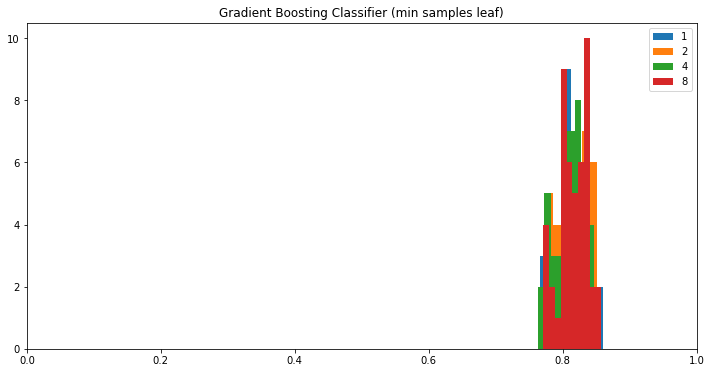

In [401]:
showaucs(GradientBoostingClassifier(min_samples_leaf=1))
showaucs(GradientBoostingClassifier(min_samples_leaf=2))
showaucs(GradientBoostingClassifier(min_samples_leaf=4))
showaucs(GradientBoostingClassifier(min_samples_leaf=8))
plt.title("Gradient Boosting Classifier (min samples leaf)")
plt.legend([1,2,4,8])

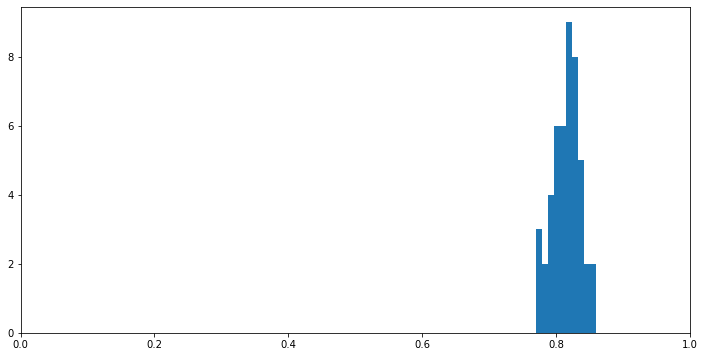

In [402]:
showaucs(GradientBoostingClassifier(min_samples_leaf=16))

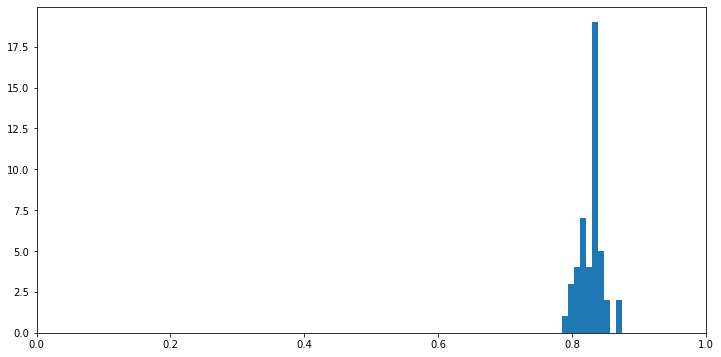

In [406]:
showaucs(GradientBoostingClassifier(min_samples_leaf=32))

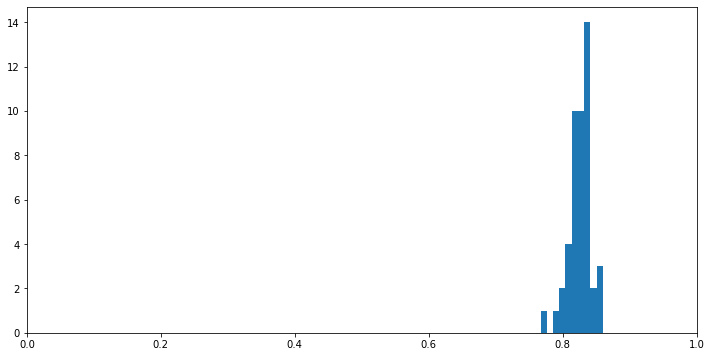

In [407]:
showaucs(GradientBoostingClassifier(min_samples_leaf=64))

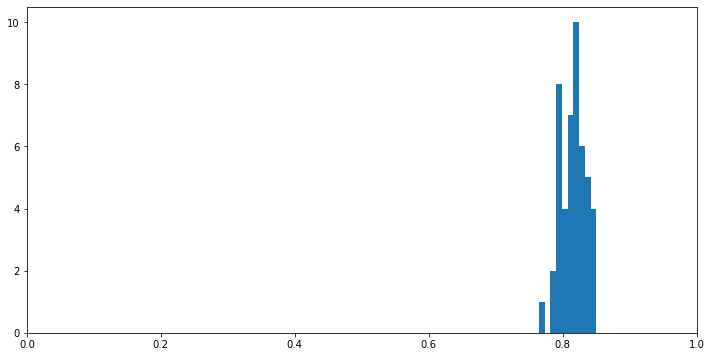

In [412]:
showaucs(GradientBoostingClassifier(min_samples_leaf=80))

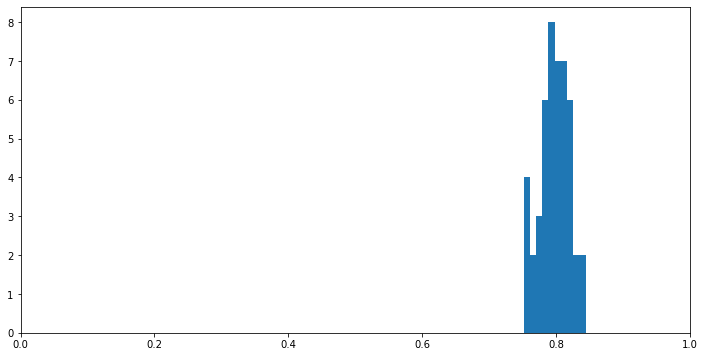

In [413]:
showaucs(GradientBoostingClassifier(min_samples_leaf=80, min_samples_split=1000))

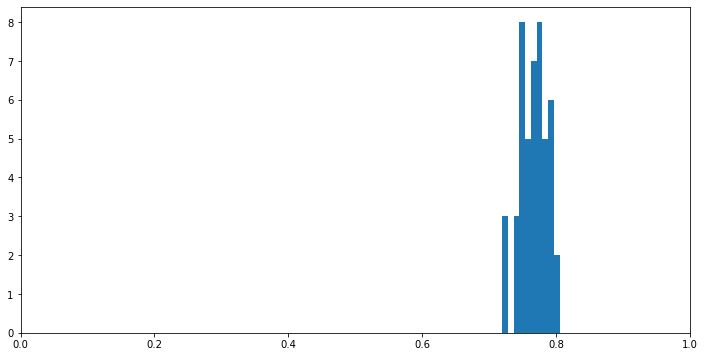

In [415]:
showaucs(AdaBoostClassifier())

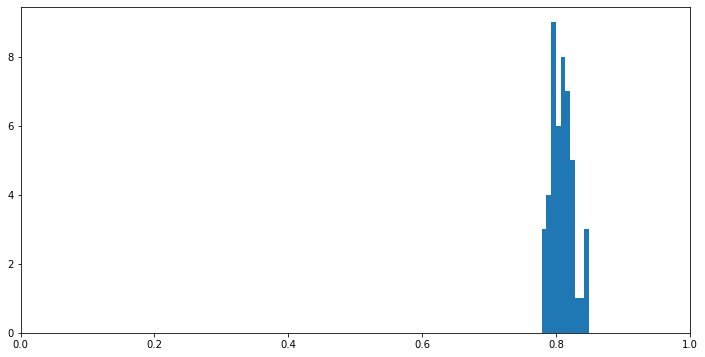

In [427]:
showaucs(AdaBoostClassifier(n_estimators=100))

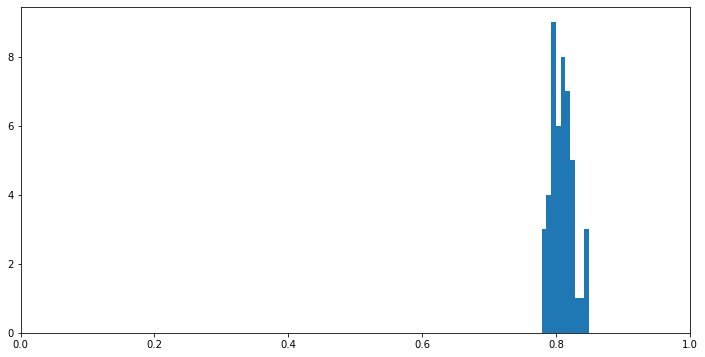

In [416]:
showaucs(AdaBoostClassifier(n_estimators = 100))

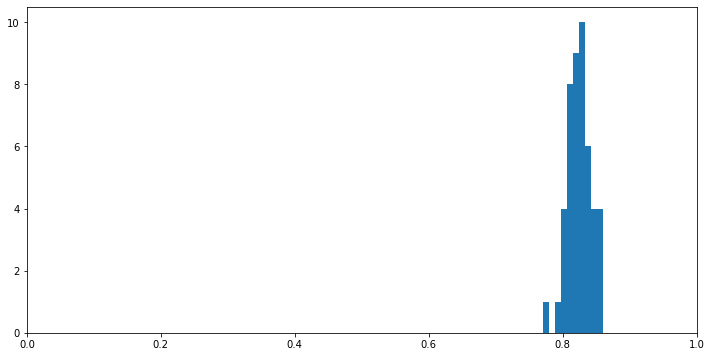

In [417]:
showaucs(AdaBoostClassifier(n_estimators = 140))

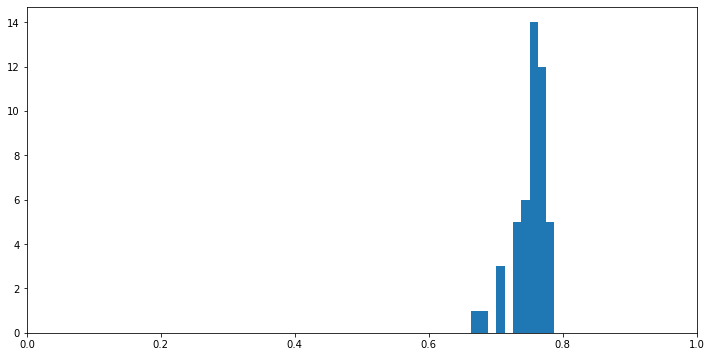

In [350]:
showaucs(AdaBoostClassifier())

In [307]:
#picking max depth of 2 from this plot

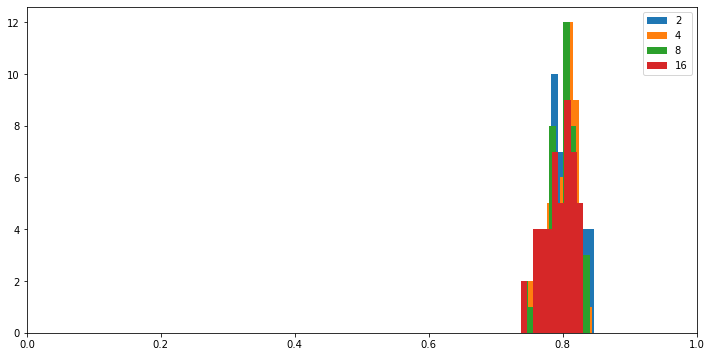

In [332]:
showaucs(RandomForestClassifier(min_samples_split=2))
showaucs(RandomForestClassifier(min_samples_split=4))
showaucs(RandomForestClassifier(min_samples_split=8))
showaucs(RandomForestClassifier(min_samples_split=16))
plt.legend([2,4,8,16])

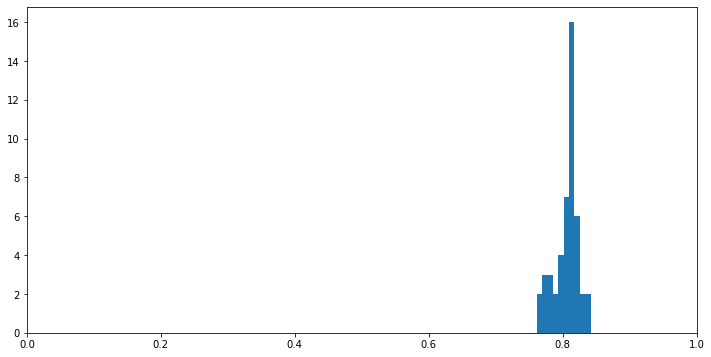

In [434]:
showaucs(RandomForestClassifier())

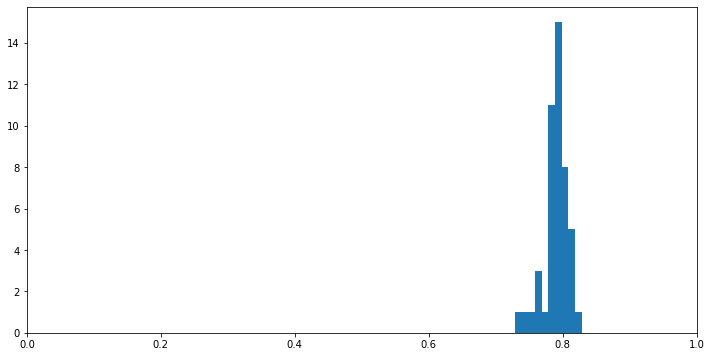

In [433]:
showaucs(RandomForestClassifier(min_samples_split=32))

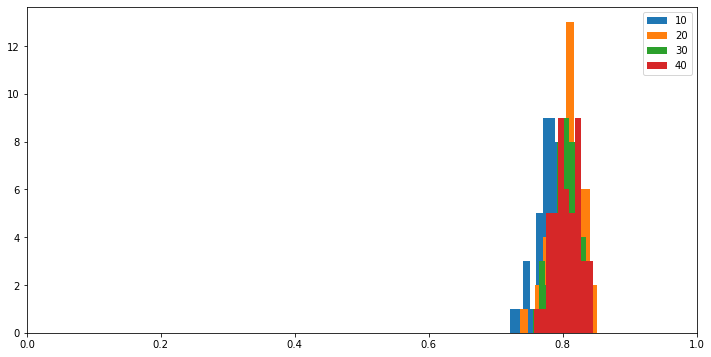

In [439]:
showaucs(RandomForestClassifier(max_depth = 10))
showaucs(RandomForestClassifier(max_depth = 20))
showaucs(RandomForestClassifier(max_depth = 30))
showaucs(RandomForestClassifier(max_depth = 40))
plt.legend([10,20,30,40])

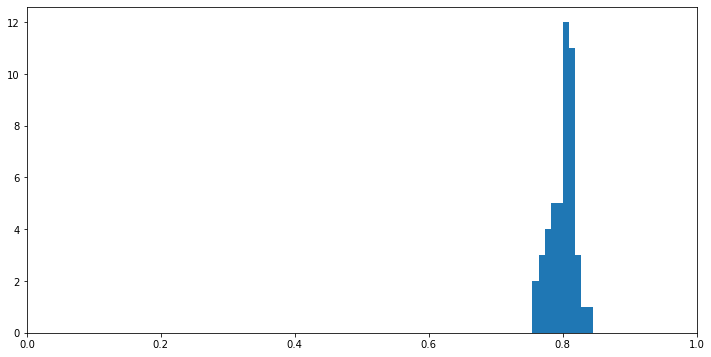

In [423]:
showaucs(RandomForestClassifier(min_samples_split=16, max_depth = 90))

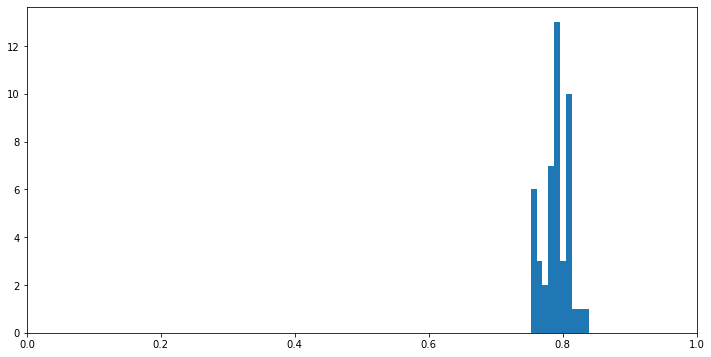

In [420]:
showaucs(RandomForestClassifier(min_samples_split=32))

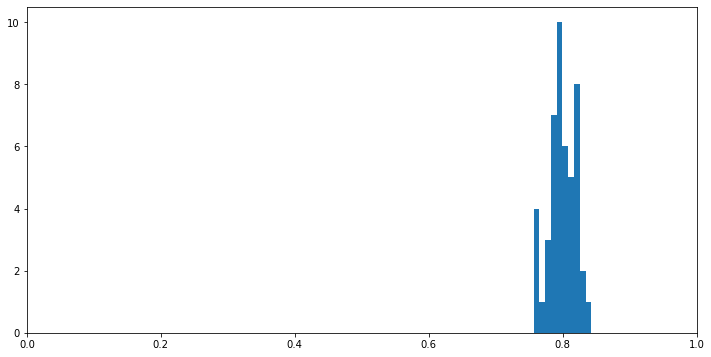

In [432]:
showaucs(RandomForestClassifier(min_samples_split=16, max_depth = 128))

# Evaluating on test set

In [430]:
def showROC(alg):
    model = alg.fit(xTrain, yTrain)
    results = model.predict(xTest)
    actual = (yTest==">30").astype(int)
    predicted = (results==">30").astype(int)
    fpr, tpr, threshold = metrics.roc_curve(actual, predicted)
    roc_auc = metrics.auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

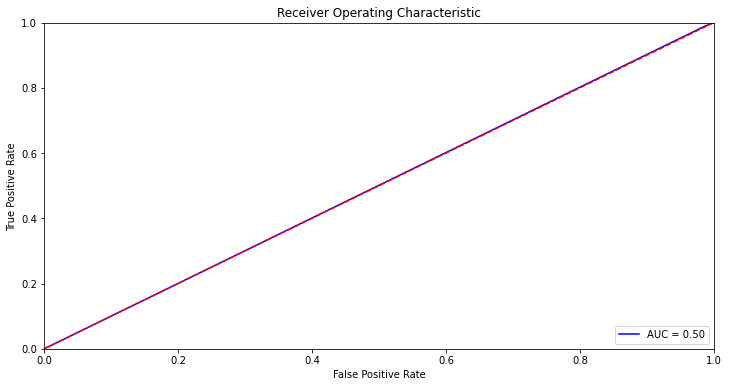

In [431]:
showROC(GradientBoostingClassifier(min_samples_leaf=80, min_samples_split=1000))